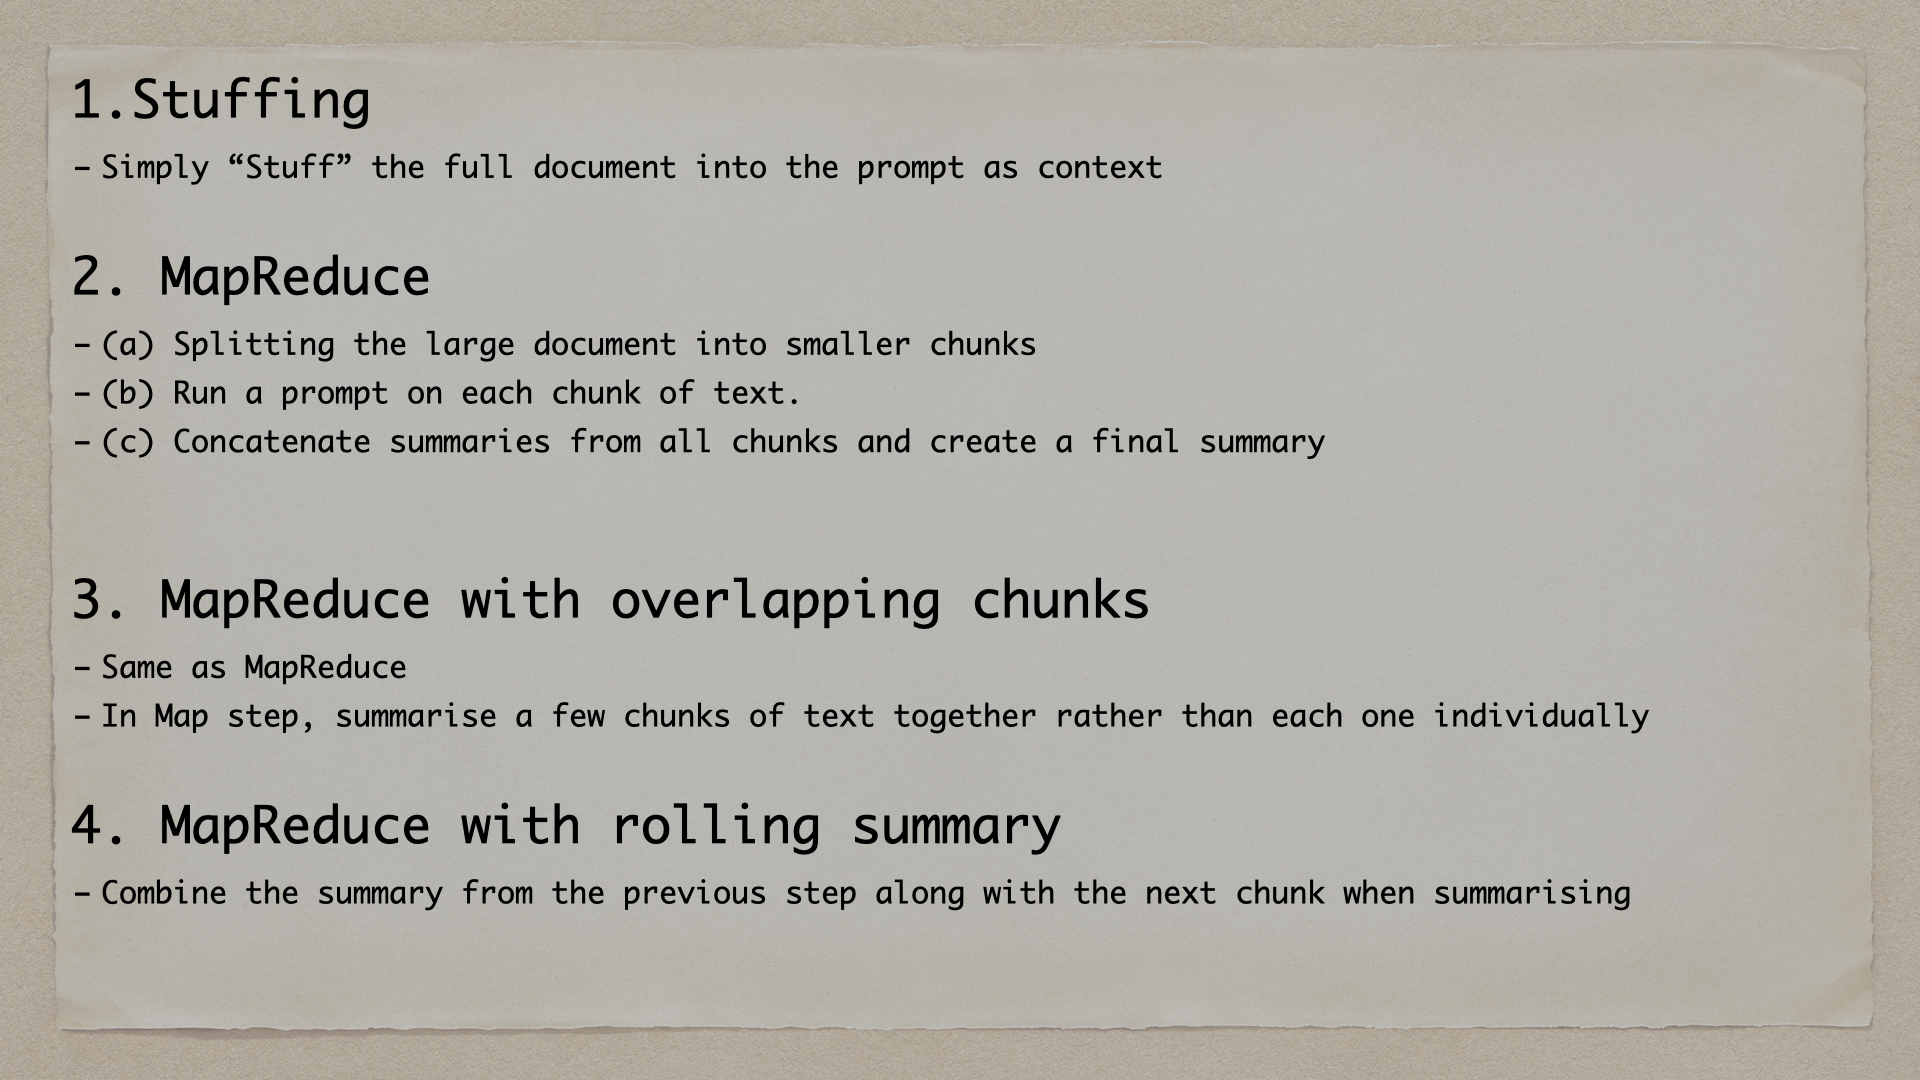

In [39]:
from IPython.display import Image
Image(filename='/Users/sridharkannam/Desktop/Youtube_Thumbnails/vertexai_llms/vertexai_llms.005.jpeg')

In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Question Answering with Large Documents using LangChain 🦜🔗

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/examples/document-qa/question_answering_large_documents_langchain.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/document-qa/question_answering_large_documents_langchain.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/language/examples/document-qa/question_answering_large_documents_langchain.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This notebook demonstrates how to build a question-answering (Q&A) system using LangChain with Vertex AI PaLM API to extract information from large documents.

The challenge with building a Q&A system over large documents is that Large Language Models, LLMs in short, have token limits that restrict how much context you can provide.

There are several methods to provide the context. They can use similarity search or not. Also there are different methods to pass context to LLMs. This notebook covers the following methods or chains:

- **Stuffing**: Push the whole document content as a context. This is the simplest method, but it can be inefficient for large documents.

- **Map-Reduce**: Split documents into smaller chunks and process them in parallel. This is more efficient than stuffing, but it can be more complex to implement.

- **Refine**: Run an initial prompt on a small chunk, generate an output and for each subsequent document, refine the output based on both output and new document. This is more efficient than Map-Reduce but less efficient.

This notebook also shows **Map-Reduce with Similarity search** where you create embeddings of smaller chunks and use vector similarity search to find relevant context. This is the most efficient method, but it can be the most complex to implement.


Learn more about [Langchain](https://python.langchain.com/en/latest/use_cases/question_answering.html) and [Vertex Generative AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)

### Objective

In this tutorial, you learn how to:

- Ingest documents which involves download the documents.
- Extract text from the PDF by using LangChain `PyPDFLoader`.
- Select context for identifying the relevant parts of the document that are needed to answer the question.
- Design prompt for question-answering
- Leverage chains for handling large contexts (with/without embeddings)

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI Generative AI Studio

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK, other packages and their dependencies

Install the following packages required to execute this notebook.

In [ ]:
# Base system dependencies
!sudo apt -y -qq install tesseract-ocr libtesseract-dev

# required by PyPDF2 for page count and other pdf utilities
!sudo apt-get -y -qq install poppler-utils python-dev libxml2-dev libxslt1-dev antiword unrtf poppler-utils pstotext tesseract-ocr flac ffmpeg lame libmad0 libsox-fmt-mp3 sox libjpeg-dev swig

In [ ]:
# Install the packages
import os

if not os.getenv("IS_TESTING"):
    USER = "--user"
else:
    USER = ""
! pip3 install {USER} --upgrade --quiet pytesseract pypdf PyPDF2 textract git+https://github.com/hwchase17/langchain.git@master transformers chromadb google-cloud-aiplatform

### Colab only: Uncomment the following cell to restart the kernel.

***Colab only***: Uncomment the following cell to restart the kernel or use the button to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top.

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
# from google.colab import auth

# auth.authenticate_user()

In [ ]:
PROJECT_ID = ""  # @param {type:"string"}
REGION = "us-central1"

import vertexai

vertexai.init(project=PROJECT_ID, location=REGION)

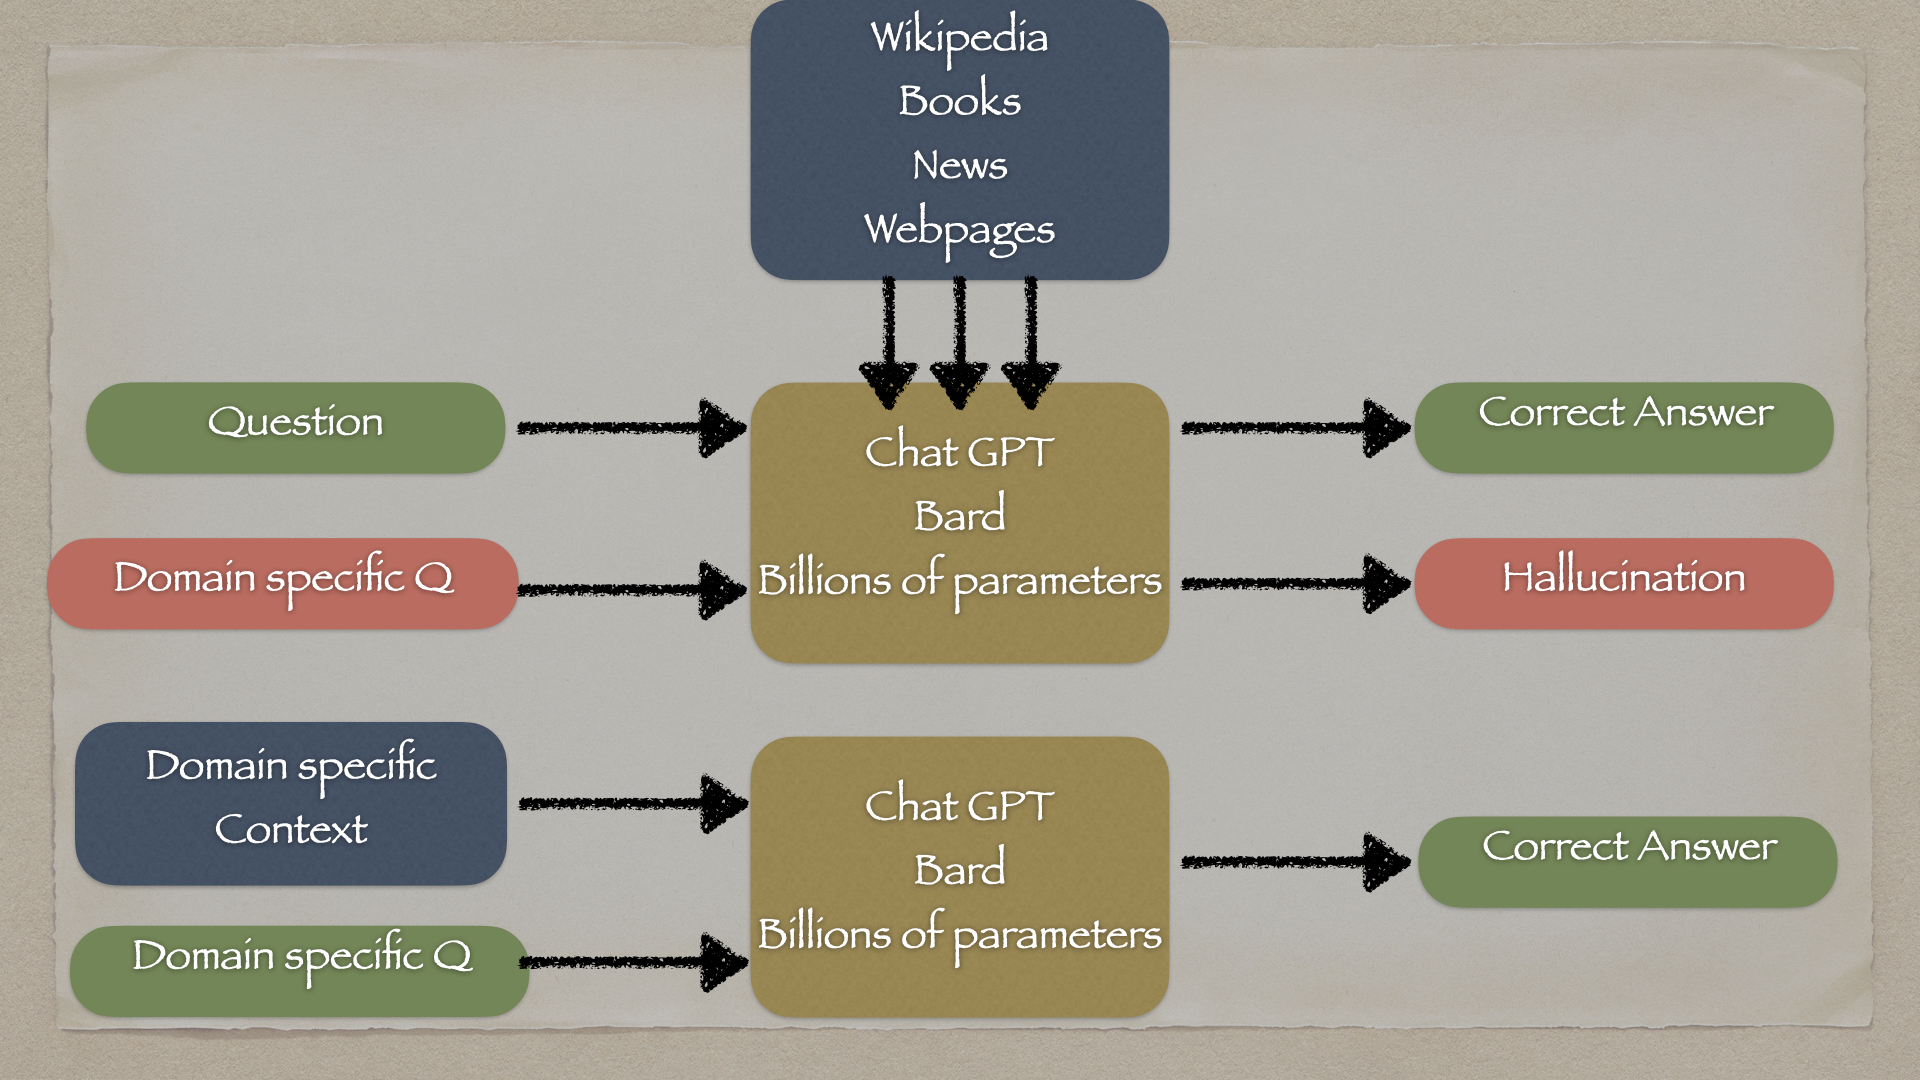

In [41]:
from IPython.display import Image
Image(filename='/Users/sridharkannam/Desktop/Youtube_Thumbnails/vertexai_llms/vertexai_llms.007.jpeg')

In [ ]:
- Semantic Search
- Non-semantic search
 -- Stuffing
 -- Map-Reduce with overlapping chunks
 -- Map-Reduce refine

### Import libraries

In [1]:
import urllib
import warnings
from pathlib import Path as p
from pprint import pprint

import pandas as pd
from langchain import PromptTemplate
from langchain.chains.question_answering import load_qa_chain
from langchain.document_loaders import PyPDFLoader
from langchain.llms import VertexAI

from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import VertexAIEmbeddings

warnings.filterwarnings("ignore")

### Import models

You load the pre-trained text and embeddings generation model called `text-bison@001` and `textembedding-gecko@001` respectively.

In [2]:
vertex_llm_text = VertexAI(model_name="text-bison@001")
vertex_embeddings = VertexAIEmbeddings(model_name="textembedding-gecko@001")

## Question Answering with large documents

Large language models (LLMs) are powerful tools that can be used to answer a wide range of questions about large document base. However, there are some challenges associated with using large language model (LLM) for question answering. One of these challenges is related with the limited knowledge of LLMs models, especially when documents are specific of some context.

One way to address this limitation is to give more information about documents using retrieval augmented generation. Retrieval augmented generation is a technique for using a large language model (LLM) to answer questions about documents it was not trained on. The basic idea is to first retrieve any relevant documents from a corpus called context, then pass those documents along with the original question to the LLM. The LLM will then generate a response that is informed by the information in the retrieved documents.


### Ingest documents

To begin, you will need to download a few files that are required for the summarizing tasks below.

In [3]:
data_folder = p.cwd() / "data"
p(data_folder).mkdir(parents=True, exist_ok=True)

pdf_url = "https://services.google.com/fh/files/misc/practitioners_guide_to_mlops_whitepaper.pdf"
pdf_file = str(p(data_folder, pdf_url.split("/")[-1]))

urllib.request.urlretrieve(pdf_url, pdf_file)

('/Users/sridharkannam/Desktop/myCourses_Code/GCP_Generative_AI/generative-ai-main/language/examples/document-qa/data/practitioners_guide_to_mlops_whitepaper.pdf',
 <http.client.HTTPMessage at 0x7fcfe60d58b0>)

### Extract text from the PDF

You use an `PdfReader` to extract the text from our scanned documents.

In [4]:
pdf_loader = PyPDFLoader(pdf_file)
pages = pdf_loader.load_and_split()
print(pages[0].page_content)

Practitioners guide to MLOps:  
A framework for continuous 
delivery and automation of  
machine learning.White paper
May 2021
Authors:  
Khalid Salama,  
Jarek Kazmierczak,  
Donna Schut


### Prompt Design

In a Q&A system, you define a question and the associated prompt.

The question is simply a string that represents the question that the application will be asked to answer. In this case, the question is ```"What is Experimentation?"```

The prompt is a string that contains the context that the application will use to generate an answer to the question. In this case, the prompt is

```
Answer the question as precise as possible using the provided context.
If the answer is not contained in the context, say "answer not available in context" \n\n

Context: \n {context}?\n
Question: \n {question} \n
Answer:
```

In [5]:
question = "What is Experimentation?"
question = "What is MLOps?"

prompt_template = """Answer the question as precise as possible using the provided context. If the answer is
                    not contained in the context, say "answer not available in context" \n\n
                    Context: \n {context}?\n
                    Question: \n {question} \n
                    Answer:
                  """

prompt = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

### Q&A without similarity search

About providing the context, you can provide it or you may use part of the text you are looking for answer.

In this example, you select the first eight pages as context of your Q&A system.

#### Context Selection

In [42]:
context = "\n".join(str(p.page_content) for p in pages[:7])
print("The total chars in the context: ", len(context))

The total chars in the context:  12076


#### Q&A Methods or Chains

##### Method 1: Stuffing

`Stuffing` is a simple method for applying large language models (LLMs) to question-answering. It involves providing the LLM with all of the relevant data as context in the prompt.

In LangChain, you can use `StuffDocumentsChain` as part of the `load_qa_chain` method. What you need to do is setting `stuff` as `chain_type` of your chain.

In [7]:
stuff_chain = load_qa_chain(vertex_llm_text, chain_type="stuff", prompt=prompt)

After you initialize a `load_qa_chain` chain, you can answer your question based on the input documents.

In [8]:
stuff_answer = stuff_chain(
    {"input_documents": pages[7:10], "question": question}, return_only_outputs=True
)

In [9]:
pprint(stuff_answer)

{'output_text': 'MLOps is a set of practices that combines software '
                'engineering, data science, and IT operations to \n'
                'deliver and manage ML models in production.'}


In [10]:
question2 = "What is vector database?"
stuff_answer = stuff_chain(
    {"input_documents": pages[7:10], "question": question2}, return_only_outputs=True
)
pprint(stuff_answer)

{'output_text': 'answer not available in context'}


The `Stuffing` method has the advantage of only requiring a single call to the LLM, but it is limited by the LLM's context length and is not feasible for large amounts of data.

Below you see an exception raising when the context reach the LLMs limit.

In [11]:
try:
    print(
        stuff_chain(
            {"input_documents": pages, "question": question},
            return_only_outputs=True,
        )
    )
except Exception as e:
    print(
        "The code failed since it won't be able to run inference on such a huge context and throws this exception: ",
        e,
    )

The code failed since it won't be able to run inference on such a huge context and throws this exception:  400 Request contains an invalid argument.


##### Method 2: MapReduce

With `MapReduce`, you can overcome the context limit. It involves dividing the document into chunks, running an initial prompt on each chunk, and then combining the results of the initial prompts using a different prompt.

In LangChain, you can use `MapReduceDocumentsChain` as part of the `load_qa_chain` method with `map_reduce` as `chain_type` of your chain.

The `load_qa_chain` with `map_reduce` as `chain_type` requires two prompts, question and a combine prompts.

The question prompt is used to ask the LLM to answer a question based on the provided context. In this case, the `question_prompt` is

```
Answer the question as precise as possible using the provided context. \n\n
Context: \n {context} \n
Question: \n {question} \n
Answer:
```

The combine prompt object is used to combine the extracted content and the question to create a final answer. In this case, the `combine_prompt` is

```
Given the extracted content and the question, create a final answer.
If the answer is not contained in the context, say "answer not available in context. \n\n
Summaries: \n {summaries}?\n
Question: \n {question} \n
Answer:
```


In [12]:
question_prompt_template = """
                    Answer the question as precise as possible using the provided context. \n\n
                    Context: \n {context} \n
                    Question: \n {question} \n
                    Answer:
                    """
question_prompt = PromptTemplate(
    template=question_prompt_template, input_variables=["context", "question"]
)

# summaries is required. a bit confusing.
combine_prompt_template = """Given the extracted content and the question, create a final answer.
If the answer is not contained in the context, say "answer not available in context. \n\n
Summaries: \n {summaries}?\n
Question: \n {question} \n
Answer:
"""
combine_prompt = PromptTemplate(
    template=combine_prompt_template, input_variables=["summaries", "question"]
)

After you define expected prompt, you initialize a `load_qa_chain` chain.

In [13]:
map_reduce_chain = load_qa_chain(
    vertex_llm_text,
    chain_type="map_reduce",
    return_intermediate_steps=True,
    question_prompt=question_prompt,
    combine_prompt=combine_prompt,
)

And you answer your question based on the input documents. Notice how you are passing entire document base.

In [14]:
map_reduce_outputs = map_reduce_chain({"input_documents": pages, "question": question})


Retrying langchain.llms.vertexai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas..
Retrying langchain.llms.vertexai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas..
Retrying langchain.llms.vertexai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google

In [15]:
map_reduce_outputs['output_text']

'A framework for continuous delivery and automation of machine learning.'

You can store answers in a Pandas dataframe for checking the `MapReduce` intermidiate steps and the LLMs answer.

In [16]:
final_mp_data = []

# for each document, extract metadata and intermediate steps of the MapReduce process
for doc, out in zip(
    map_reduce_outputs["input_documents"], map_reduce_outputs["intermediate_steps"]
):
    output = {}
    output["file_name"] = p(doc.metadata["source"]).stem
    output["file_type"] = p(doc.metadata["source"]).suffix
    output["page_number"] = doc.metadata["page"]
    output["chunks"] = doc.page_content
    output["answer"] = out
    final_mp_data.append(output)

In [17]:
# create a dataframe from a dictionary
pdf_mp_answers = pd.DataFrame.from_dict(final_mp_data)
# sorting the dataframe by filename and page_number
pdf_mp_answers = pdf_mp_answers.sort_values(by=["file_name", "page_number"])
pdf_mp_answers.reset_index(inplace=True, drop=True)
pdf_mp_answers.head()

file_name file_type  page_number  \
0  practitioners_guide_to_mlops_whitepaper      .pdf            0   
1  practitioners_guide_to_mlops_whitepaper      .pdf            1   
2  practitioners_guide_to_mlops_whitepaper      .pdf            2   
3  practitioners_guide_to_mlops_whitepaper      .pdf            3   
4  practitioners_guide_to_mlops_whitepaper      .pdf            4   

                                              chunks  \
0  Practitioners guide to MLOps:  \nA framework f...   
1  Table of Contents\nExecutive summary  3\nOverv...   
2  Executive summary\nAcross industries, DevOps a...   
3  4\nOrganizations can use the framework to iden...   
4  5\nprocesses in place is one of the differenti...   

                                              answer  
0  A framework for continuous delivery and automa...  
1  MLOps is the practice of integrating machine l...  
2  MLOps is a set of standardized processes and t...  
3  MLOps is a set of practices that combines soft...  
4  MLOps is a methodology for ML engineering that...

In [43]:
len(pdf_mp_answers)

36

In [18]:
index = 0
print("[Context]")
print(pdf_mp_answers["chunks"].iloc[index])
print("\n\n [Answer]")
print(pdf_mp_answers["answer"].iloc[index])
print("\n\n [Page number]")
print(pdf_mp_answers["page_number"].iloc[index])
print("\n\n [Source: file_name]")
print(pdf_mp_answers["file_name"].iloc[index])

[Context]
Practitioners guide to MLOps:  
A framework for continuous 
delivery and automation of  
machine learning.White paper
May 2021
Authors:  
Khalid Salama,  
Jarek Kazmierczak,  
Donna Schut


 [Answer]
A framework for continuous delivery and automation of machine learning.


 [Page number]
0


 [Source: file_name]
practitioners_guide_to_mlops_whitepaper


**Consideration**: The `MapReduce` method has the advantage of being able to scale to larger amounts of data than the stuffing method, but it requires more calls to the LLM and may lose some information during the final combined call.

##### Method 3: Refine

With `Refine` method, you try to overcome the lost of `information` of `MapReduce` method. The method involves running an initial prompt on the first chunk of data, generating some output. For the remaining documents, that output is passed in, along with the next document, asking the LLM to refine the output based on the new document.

In LangChain, you can use `MapReduceDocumentsChain` as part of the `load_qa_chain` method. What you need to do is setting `refine` as `chain_type` of your chain.

The `load_qa_chain` with `refine` as chain_type requires two prompts, refine and a initial question prompts.

The `refine prompt` is used to generate a prompt that asks the LLM to refine an existing answer based on the provided context. In this case, the `refine prompt` is:

```
The original question is: \n {question} \n
The provided answer is: \n {existing_answer}\n
Refine the existing answer if needed with the following context: \n {context_str} \n
Given the extracted content and the question, create a final answer.
If the answer is not contained in the context, say "answer not available in context. \n\n
```

The `initial question` prompt is used to generate a prompt that asks the LLM to answer a question based on the provided context only. In this case, the `initial question prompt` is:

```
Answer the question as precise as possible using the provided context only. \n\n
Context: \n {context_str} \n
Question: \n {question} \n
Answer:
```

In [19]:
refine_prompt_template = """
    The original question is: \n {question} \n
    The provided answer is: \n {existing_answer}\n
    Refine the existing answer if needed with the following context: \n {context_str} \n
    Given the extracted content and the question, create a final answer.
    If the answer is not contained in the context, say "answer not available in context. \n\n
"""
refine_prompt = PromptTemplate(
    input_variables=["question", "existing_answer", "context_str"],
    template=refine_prompt_template,
)


initial_question_prompt_template = """
    Answer the question as precise as possible using the provided context only. \n\n
    Context: \n {context_str} \n
    Question: \n {question} \n
    Answer:
"""

initial_question_prompt = PromptTemplate(
    input_variables=["context_str", "question"],
    template=initial_question_prompt_template,
)

After you define expected prompt, you initialize a `load_qa_chain` chain.

In [20]:
refine_chain = load_qa_chain(
    vertex_llm_text,
    chain_type="refine",
    return_intermediate_steps=True,
    question_prompt=initial_question_prompt,
    refine_prompt=refine_prompt,
)

And you answer your question based on the input documents. Notice how you are passing entire document base.

In [21]:
refine_outputs = refine_chain({"input_documents": pages, "question": question})


Retrying langchain.llms.vertexai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas..
Retrying langchain.llms.vertexai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas..
Retrying langchain.llms.vertexai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google

In [22]:
refine_outputs['output_text']

'MLOps is a methodology for ML engineering that unifies ML system development (the ML element) with ML system \noperations (the Ops element). It advocates formalizing and (when beneficial) automating critical steps of ML system \nconstruction. MLOps provides a set of standardized processes and technology capabilities for building, deploying, \nand operationalizing ML systems rapidly and reliably.'

You can store answers in a Pandas dataframe for checking the `Refine` intermediate steps and the LLMs answer.

In [23]:
final_refine_data = []
for doc, out in zip(
    refine_outputs["input_documents"], refine_outputs["intermediate_steps"]
):
    output = {}
    output["file_name"] = p(doc.metadata["source"]).stem
    output["file_type"] = p(doc.metadata["source"]).suffix
    output["page_number"] = doc.metadata["page"]
    output["chunks"] = doc.page_content
    output["answer"] = out
    final_refine_data.append(output)

In [24]:
pdf_refine_answers = pd.DataFrame.from_dict(final_mp_data)
pdf_refine_answers = pdf_refine_answers.sort_values(
    by=["file_name", "page_number"]
)  # sorting the dataframe by filename and page_number
pdf_refine_answers.reset_index(inplace=True, drop=True)
pdf_refine_answers.head()

file_name file_type  page_number  \
0  practitioners_guide_to_mlops_whitepaper      .pdf            0   
1  practitioners_guide_to_mlops_whitepaper      .pdf            1   
2  practitioners_guide_to_mlops_whitepaper      .pdf            2   
3  practitioners_guide_to_mlops_whitepaper      .pdf            3   
4  practitioners_guide_to_mlops_whitepaper      .pdf            4   

                                              chunks  \
0  Practitioners guide to MLOps:  \nA framework f...   
1  Table of Contents\nExecutive summary  3\nOverv...   
2  Executive summary\nAcross industries, DevOps a...   
3  4\nOrganizations can use the framework to iden...   
4  5\nprocesses in place is one of the differenti...   

                                              answer  
0  A framework for continuous delivery and automa...  
1  MLOps is the practice of integrating machine l...  
2  MLOps is a set of standardized processes and t...  
3  MLOps is a set of practices that combines soft...  
4  MLOps is a methodology for ML engineering that...

In [25]:
index = 1
print("[Context]")
print(pdf_refine_answers["chunks"].iloc[index])
print("\n\n [Answer]")
print(pdf_refine_answers["answer"].iloc[index])
print("\n\n [Page number]")
print(pdf_refine_answers["page_number"].iloc[index])
print("\n\n [Source: file_name]")
print(pdf_refine_answers["file_name"].iloc[index])

[Context]
Table of Contents
Executive summary  3
Overview of MLOps lifecycle and core capabilities  4
Deep dive of MLOps processes  15
Putting it all together  34
Additional resources  36Building an ML-enabled system  6
The MLOps lifecycle  7
MLOps: An end-to-end workflow  8
MLOps capabilities  9
      Experimentation  11
      Data processing  11
      Model training  11
      Model evaluation  12
      Model serving  12
      Online experimentation  13
      Model monitoring  13
      ML pipelines  13
      Model registry  14
      Dataset and feature repository  14
      ML metadata and artifact tracking  15
ML development  16
Training operationalization  18
Continuous training  20
Model deployment  23
Prediction serving  25
Continuous monitoring  26
Data and model management  29
      Dataset and feature management  29
             Feature management  30
             Dataset management  31
      Model management  32
             ML metadata tracking  32
             Model governanc

**Consideration**: So far, you use both part of the document or the entire document as the context to answer your specific question. Both cases have several limitations, including incomplete context and slow to query, especially for large context.

Similarity search over a vector database, is a newer approach that addresses these limitations.


### Q&A with similarity search

With similarity search over a vector database, each piece of context is represented as a vector. These vectors are then stored in a database. When a user asks a question, the system first calculates the similarity between the question and the vectors in the database. The most similar vectors are then used to fetch the context that is relevant to the question.

This approach has several advantages including more accurate context with respect of the user's question.

In this case, you use `Chroma` an in-memory open-source embedding database to create similarity search index.

#### Context Selection

Split the document content.

In [26]:
text_splitter = CharacterTextSplitter(chunk_size=10000, chunk_overlap=0)
context = "\n\n".join(str(p.page_content) for p in pages)
texts = text_splitter.split_text(context)

In [44]:
len(texts)

7

Then, create the similarity search index using `Chroma`

In [27]:
Chromavector_index = .from_texts(texts, vertex_embeddings).as_retriever()

Next, retrieve relevant context using the original question.

In [28]:
docs = vector_index.get_relevant_documents(question)

In [29]:
print(len(docs))
docs

4


[Document(page_content='12\nModel training should be able to scale with the size of both the models and the datasets that are used for training. \nKey functionalities in model training include the following:\n• Support common ML frameworks and support custom runtime environments.\n• Support large-scale distributed training with different strategies for multiple GPUs and multiple workers.\n• Enable on-demand use of ML accelerators.\n• Allow efficient hyperparameter tuning and target optimization at scale.\n• Ideally, provide built-in automated ML (AutoML) functionality, including automated feature selection and engi -\nneering as well as automated model architecture search and selection.\nModel evaluation\nThe model evaluation capability lets you assess the effectiveness of your model, interactively during experimentation \nand automatically in production. Key functionalities in model evaluation include the following:\n• Perform batch scoring of your models on evaluation datasets at sca

#### MapReduce method

Finally you answer your question based on the context you retrive with embeddings database and the input question.


In [30]:
map_reduce_embeddings_outputs = map_reduce_chain(
    {"input_documents": docs, "question": question}
)

In [31]:
print(map_reduce_embeddings_outputs["output_text"])

MLOps is a set of practices that help organizations operationalize machine learning (ML) models. It is a 
cross-functional approach that brings together people, processes, and technologies to ensure that ML models are 
developed, deployed, and managed effectively.


## Conclusion

This notebook demonstrates how to build a question-answering (QA) system using LangChain with Vertex AI PaLM API to extract information from large documents.

In this case, you use Chroma, an in-memory open-source embedding database to create similarity search index. But [Langchain](https://github.com/hwchase17/langchain/blob/master/docs/modules/indexes/vectorstores/examples/matchingengine.ipynb) supports Vertex AI Matching Engine, the Google Cloud high-scale low latency vector database. With Vertex AI Matching Engine, you have a fully managed service that can scale to meet the needs of even the most demanding applications. It provides high performance for both training and inference. And it has several features including support for multiple similarity metrics, batch inference, and online learning. These features can be important for applications that need to perform complex matching tasks or that need to be able to adapt to changing data.

In [32]:
for index in range(36):
    ans = pdf_mp_answers["answer"].iloc[index]
    #ans = pdf_refine_answers["answer"].iloc[index]
    #if "answer not available in context" in ans:
    print(index, len(ans))

0 71
1 264
2 147
3 173
4 395
5 118
6 206
7 143
8 143
9 382
10 137
11 187
12 183
13 226
14 135
15 186
16 93
17 167
18 147
19 181
20 143
21 123
22 187
23 169
24 144
25 93
26 200
27 147
28 193
29 59
30 187
31 123
32 154
33 241
34 180
35 71


In [33]:
print(pdf_refine_answers["answer"].iloc[0])
print()
print(pdf_refine_answers["answer"].iloc[35])
print()
print(pdf_refine_answers["answer"].iloc[29])
print()
print(pdf_refine_answers["answer"].iloc[13])

A framework for continuous delivery and automation of machine learning.

MLOps: Continuous delivery and automation pipelines in machine learning

MLOps is a unified repository for ML features and datasets.

MLOps is a set of practices that help organizations operationalize machine learning. It includes the processes, tools, and workflows for managing the entire lifecycle of ML models, from development to deployment to monitoring.


In [34]:
print(pdf_mp_answers["answer"].iloc[0])
print()
print(pdf_mp_answers["answer"].iloc[35])
print()
print(pdf_mp_answers["answer"].iloc[29])

A framework for continuous delivery and automation of machine learning.

MLOps: Continuous delivery and automation pipelines in machine learning

MLOps is a unified repository for ML features and datasets.


In [35]:
map_reduce_outputs.keys() #['output_text']

dict_keys(['input_documents', 'question', 'intermediate_steps', 'output_text'])

In [36]:
map_reduce_outputs['intermediate_steps']

['A framework for continuous delivery and automation of machine learning.',
 'MLOps is the practice of integrating machine learning (ML) into the software development lifecycle (SDLC). It is a set of practices that help organizations manage the entire ML lifecycle, from data preparation and model training to model deployment and monitoring.',
 'MLOps is a set of standardized processes and technology capabilities for building, deploying, and operationalizing ML systems rapidly and reliably.',
 'MLOps is a set of practices that combines software engineering, data science, and IT operations to \nensure that machine learning models are deployed and managed effectively.',
 'MLOps is a methodology for ML engineering that unifies ML system development (the ML element) with ML system \noperations (the Ops element). It advocates formalizing and (when beneficial) automating critical steps of ML system \nconstruction. MLOps provides a set of standardized processes and technology capabilities for 